In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from sklearn.decomposition import PCA
import sklearn.cluster

In [2]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


# Preprocessing

In [9]:
category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}


season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

cats = ['MAX_CAT', 'SEASON', 'REGION_M', 'TOR_F']
dicts = [category_dict, season_dict, region_dict, tor_dict]

In [33]:
# remove unneeded variables and x, y dimensions
data = pph.drop(['lat', 'lon', 'p_perfect_wind', 'p_perfect_sig_wind', 'p_perfect_hail', 'p_perfect_sig_hail', 'p_perfect_tor', 'p_perfect_sig_tor', 'RAMP_CAT', 'p_perfect_total', 'p_perfect_max', 'PPH_CAT', 'PPH_NUM', 'PPH_D_CAT', 'WINDSP_CAT', 'HAILSZ_CAT', 'REGION'])


# make data numerical
def convert_strings_to_ints(data, conversion_dict):
    return np.vectorize(conversion_dict.get)(data)

for cat, dic in zip(cats, dicts):

    data[cat] = xr.apply_ufunc(
        convert_strings_to_ints,  # function to apply
        data[cat],      # input data
        kwargs={'conversion_dict': dic},  # additional arguments
        vectorize=True            # vectorize the function
    )

In [11]:
# consolidate dates 
earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))

In [34]:
earliest_date = '200203300000'
all_pph_dates = data['time']
pph_dates = all_pph_dates[all_pph_dates <= latest_date]
pph_dates = pph_dates[pph_dates >= earliest_date]
new_data = data.sel(time = pph_dates)

In [36]:
def standardize_dataset(dataset):
    standardized_data = {}
    for var in dataset.data_vars:
        data_array = dataset[var]
        mean = data_array.mean()
        std = data_array.std()
        standardized_data[var] = (data_array - mean) / std
    return xr.Dataset(standardized_data)

new_data = standardize_dataset(new_data)

# PCA

In [37]:
# do pca
data_matrix = new_data.to_array(dim = 'time').data.T
pca = PCA()

pca.fit(data_matrix)

PCA()

PC 0
MAX_CAT: 0.2655724965181635
RAMP_UP: 0.12239415628483563
RAMP_DOWN: -0.005247741628543211
SEASON: 0.05484497532505634
REPORT_NUM: 0.31171699157400123
TOR_NUM: 0.1875760681770589
WIND_NUM: 0.28640373789018103
HAIL_NUM: 0.25188974324393515
TOR_F: 0.2377216637725521
WINDSP_NUM: 0.2645549136188473
HAILSZ_NUM: 0.2700336731166719
NEIGH_NUM: 0.2867345122446896
RMSE_NUM: 0.31446631436327066
BS_NUM: 0.31802878345645164
REGION_M: 0.2003679754299679
LAT_NUM: 0.04652650515160392
LON_NUM: 0.08740415344716025
PPH_D_NUM: 0.319388395720719
PC 1
MAX_CAT: -0.2516827236049598
RAMP_UP: -0.28815434885119146
RAMP_DOWN: 0.1731593543359592
SEASON: -0.05031079282377108
REPORT_NUM: 0.22676647963466218
TOR_NUM: 0.012823388946731462
WIND_NUM: 0.23037454382716885
HAIL_NUM: 0.1746596396372258
TOR_F: -0.1513801168340785
WINDSP_NUM: -0.2549109070495599
HAILSZ_NUM: -0.0365423340490231
NEIGH_NUM: 0.2485534168066721
RMSE_NUM: 0.1114231448457322
BS_NUM: 0.1561575489992077
REGION_M: -0.5109433400785625
LAT_NUM: 0.381

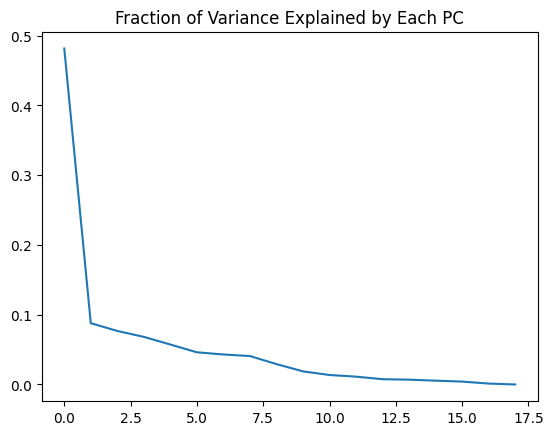

In [38]:
# Print variance expained and componenets of first PCs
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_))
plt.title('Fraction of Variance Explained by Each PC')
keys = list(new_data.keys())
for i in range(6):
    print('PC ' + str(i))
    pc = pca.components_[i, :]
    for j in range(len(pc)):
        print(keys[j] + ': ' + str(pc[j]))
    

# Clustering

In [39]:
# cluster with, k-means, knn, optics, birch, dbscan look here for use cases https://scikit-learn.org/stable/modules/clustering.html
pca.explained_variance_/np.sum(pca.explained_variance_)

array([4.81734790e-01, 8.79091580e-02, 7.67312437e-02, 6.82643655e-02,
       5.72650592e-02, 4.61512295e-02, 4.30074584e-02, 4.07560590e-02,
       2.92528022e-02, 1.87723235e-02, 1.36045005e-02, 1.12076322e-02,
       7.56588714e-03, 6.87968399e-03, 5.46331058e-03, 4.13115990e-03,
       1.30333704e-03, 4.15461265e-30])